# Argo Vertical Spectra

This notebook is based on Dhruv's vertical_spectra notebook with glider data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Useful functions (separate for glider & argo)

In [2]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
        
    temp_filt=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))
    for n in range(0,num):
        temp_filt[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')
    ds_filt=xr.DataArray(temp_filt,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})
    return ds_filt

def glider_var(ds_interp,ds_filt,variable='CT'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-ds_interp.CT).var()
    return var

In [3]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

### Glider data, filtering & spectra

In [4]:
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
ds_660_filt=glider_ds_filt(ds_660_grid,1,4,50)
ds_660_var=glider_var(ds_660_grid,ds_660_filt)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, 

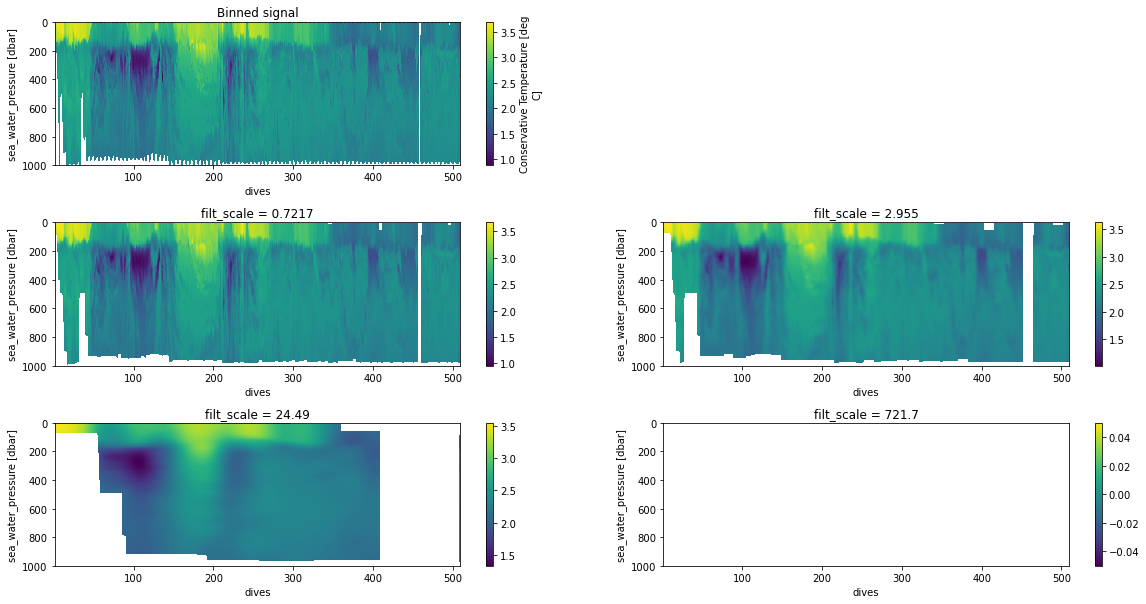

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
ds_660_grid.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
ds_660_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
ds_660_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
ds_660_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
ds_660_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

In [6]:
select=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
select_filt=glider_ds_filt(select,1,3,50)
select_var=glider_var(select,select_filt)

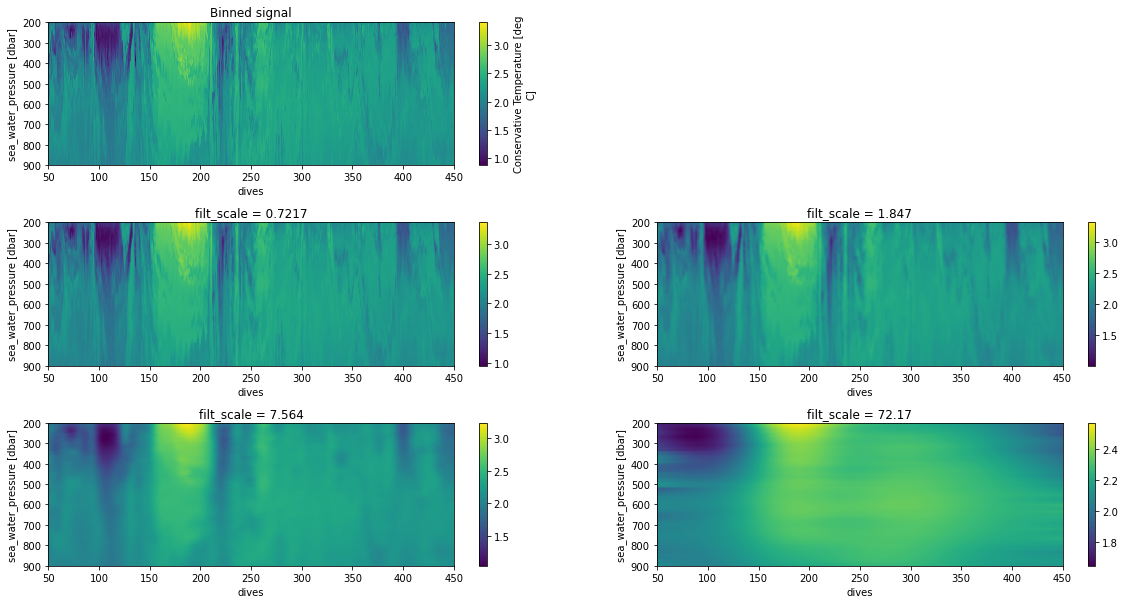

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
select.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
select_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
select_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
select_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
select_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

Text(0, 0.5, 'Variance ($^oC^2$)')

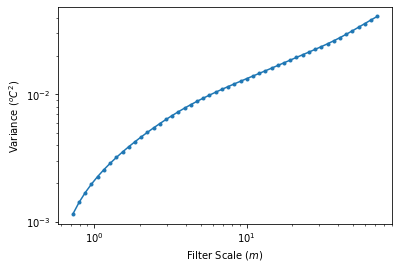

In [8]:
plt.plot(select_filt.filt_scale,select_var,'.-')

#kz = select_filt.freq_ctd_pressure
#plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
#plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [9]:
select_CT_spec=xrft.power_spectrum(select.CT.dropna(dim='dives') - select.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 0, '$\\lambda$ [1/m]')

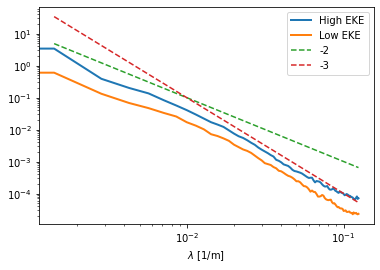

In [60]:
select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = select_CT_spec.freq_ctd_pressure

plt.plot(kz, 1e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

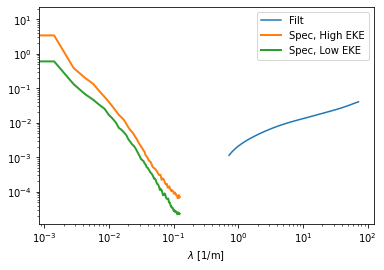

In [11]:
plt.plot(select_filt.filt_scale,select_var,label='Filt')

select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='Spec, High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Spec, Low EKE', linewidth=2)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

### Glider data, event-based visual selections

In [67]:
select1=ds_660_grid.sel(dives=slice(50,75),ctd_pressure=slice(200,900))
select1_filt=glider_ds_filt(select1,1,3,50)
select1_var=glider_var(select1,select1_filt)

select2=ds_660_grid.sel(dives=slice(100,125),ctd_pressure=slice(200,900))
select2_filt=glider_ds_filt(select2,1,3,50)
select2_var=glider_var(select2,select2_filt)

select3=ds_660_grid.sel(dives=slice(175,200),ctd_pressure=slice(200,900))
select3_filt=glider_ds_filt(select3,1,3,50)
select3_var=glider_var(select3,select3_filt)

select4=ds_660_grid.sel(dives=slice(275,325),ctd_pressure=slice(200,900))
select4_filt=glider_ds_filt(select4,1,3,50)
select4_var=glider_var(select4,select4_filt)

select5=ds_660_grid.sel(dives=slice(375,450),ctd_pressure=slice(200,900))
select5_filt=glider_ds_filt(select5,1,3,50)
select5_var=glider_var(select5,select5_filt)

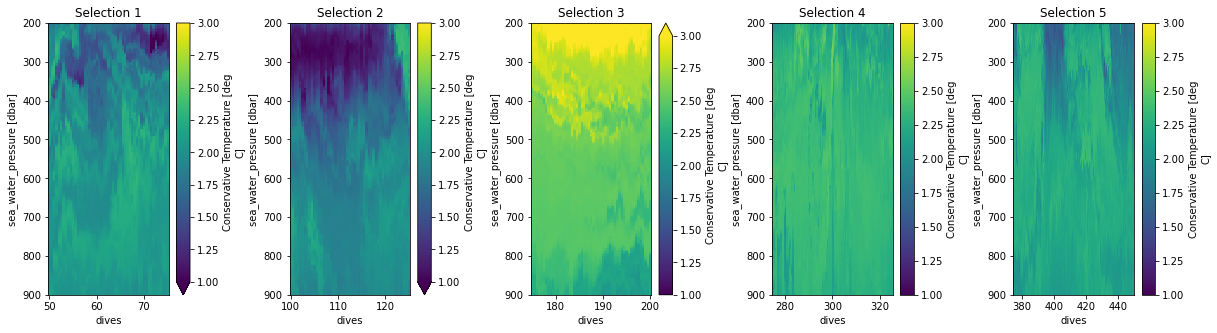

In [68]:
plt.figure(figsize=(20,5))
cbar_min=1
cbar_max=3

plt.subplot(1,5,1)
select1.CT.plot(x='dives',y='ctd_pressure',vmin=cbar_min,vmax=cbar_max)
plt.gca().invert_yaxis()
plt.title('Selection 1')

plt.subplot(1,5,2)
select2.CT.plot(x='dives',y='ctd_pressure',vmin=cbar_min,vmax=cbar_max)
plt.gca().invert_yaxis()
plt.title('Selection 2')

plt.subplot(1,5,3)
select3.CT.plot(x='dives',y='ctd_pressure',vmin=cbar_min,vmax=cbar_max)
plt.gca().invert_yaxis()
plt.title('Selection 3')

plt.subplot(1,5,4)
select4.CT.plot(x='dives',y='ctd_pressure',vmin=cbar_min,vmax=cbar_max)
plt.gca().invert_yaxis()
plt.title('Selection 4')

plt.subplot(1,5,5)
select5.CT.plot(x='dives',y='ctd_pressure',vmin=cbar_min,vmax=cbar_max)
plt.gca().invert_yaxis()
plt.title('Selection 5')

plt.subplots_adjust(hspace=0.2,wspace=0.6)

In [138]:
select1_CT_spec=xrft.power_spectrum(select1.CT.dropna(dim='dives') - select1.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)
select2_CT_spec=xrft.power_spectrum(select2.CT.dropna(dim='dives') - select2.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)
select3_CT_spec=xrft.power_spectrum(select3.CT.dropna(dim='dives') - select3.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)
select4_CT_spec=xrft.power_spectrum(select4.CT.dropna(dim='dives') - select4.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)
select5_CT_spec=xrft.power_spectrum(select5.CT.dropna(dim='dives') - select5.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/pytho

Text(0.5, 1.0, 'Variance from Filtering')

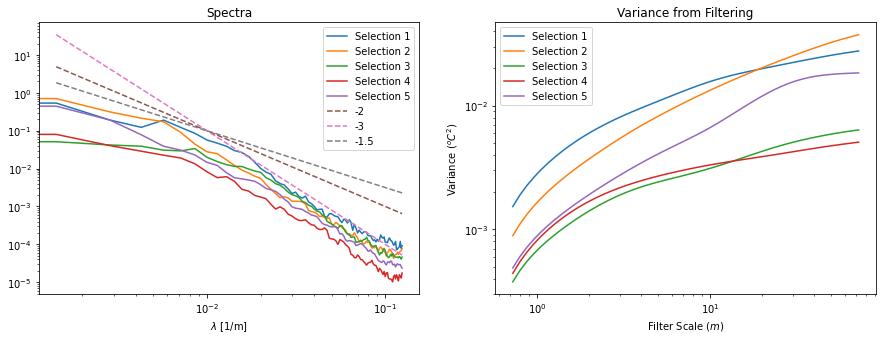

In [128]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
select1_CT_spec.mean('dives').plot(label='Selection 1')
select2_CT_spec.mean('dives').plot(label='Selection 2')
select3_CT_spec.mean('dives').plot(label='Selection 3')
select4_CT_spec.mean('dives').plot(label='Selection 4')
select5_CT_spec.mean('dives').plot(label='Selection 5')
kz = select_CT_spec.freq_ctd_pressure

plt.plot(kz, 1e-5*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')
plt.plot(kz, 1e-4*kz**(-1.5), '--', label='-1.5')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.title('Spectra')

plt.subplot(1,2,2)
plt.plot(select1_filt.filt_scale,select1_var,label='Selection 1')
plt.plot(select2_filt.filt_scale,select2_var,label='Selection 2')
plt.plot(select3_filt.filt_scale,select3_var,label='Selection 3')
plt.plot(select4_filt.filt_scale,select4_var,label='Selection 4')
plt.plot(select5_filt.filt_scale,select5_var,label='Selection 5')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.title('Variance from Filtering')

In [469]:
t_min,t_max,b_min,b_max=200,300,800,900

top1,bottom1,overall1=temp_averages(select1,t_min,t_max,b_min,b_max)
top2,bottom2,overall2=temp_averages(select2,t_min,t_max,b_min,b_max)
top3,bottom3,overall3=temp_averages(select3,t_min,t_max,b_min,b_max)
top4,bottom4,overall4=temp_averages(select4,t_min,t_max,b_min,b_max)
top5,bottom5,overall5=temp_averages(select5,t_min,t_max,b_min,b_max)

In [470]:
print("av[{},{}]:{} {} {} {} {}".format(t_min,t_max,top1,top2,top3,top4,top5))

av[200,300]:1.6516676364060585 1.3156712693648078 2.9820747602505504 2.236755568255817 2.0337322101191995


In [472]:
print("av[{},{}]:{} {} {} {} {}".format(b_min,b_max,bottom1,bottom2,bottom3,bottom4,bottom5))

av[800,900]:2.0753458444827753 1.9656329101035654 2.2506314804332623 2.279282423734419 2.1479040274857817


In [473]:
print("av[{},{}]-av[{},{}]:{} {} {} {} {}".format(t_min,t_max,b_min,b_max,overall1,overall2,overall3,overall4,overall5))

av[200,300]-av[800,900]:-0.42367820807671674 -0.6499616407387576 0.7314432798172881 -0.0425268554786018 -0.11417181736658222


In [474]:
def temp_averages(ds,top_min,top_max,bottom_min,bottom_max):
    top=float(ds.CT.sel(ctd_pressure=slice(top_min,top_max)).mean())
    bottom=float(ds.CT.sel(ctd_pressure=slice(bottom_min,bottom_max)).mean())
    overall=top-bottom
    return top,bottom,overall

#### Trying again below here

In [403]:
ds_interp=select
first=1
last=3
num=50
variable='CT'



for d in select.dives:
    dive=select.sel(dives=d)
    dive_filt=select_filt.sel(dives=d)
    dive_var=glider_var(dive,dive_filt)
    
    #var
    #spec

In [ ]:
 ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)

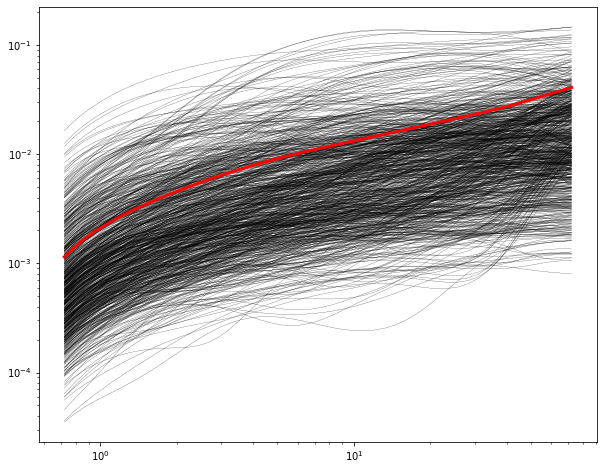

In [448]:
plt.figure(figsize=(10,8))
for n in range(0,len(select_filt.dives)):
    dive=select.isel(dives=n)
    dive_filt=select_filt.isel(dives=n)
    dive_var=glider_var(dive,dive_filt)
    plt.plot(dive_filt.filt_scale,dive_var,linewidth=0.2,color='0')
    
plt.xscale('log')
plt.yscale('log')
plt.plot(select_filt.filt_scale,select_var,linewidth=3,color='r')

### Argo data, filtering & Spectra

In [12]:
box=xr.open_dataset('202206_lon:(30,39)_lat:(-54,-50).nc')
box_interp=get_ds_interp(box,200,1000,4)
box_filt=get_ds_filt(box_interp,1,3,50)
box_var=get_var(box_interp,box_filt)

In [23]:
min(box.TIME)

<xarray.DataArray 'TIME' ()>
array('2002-02-27T04:02:50.000000000', dtype='datetime64[ns]')
Coordinates:
    N_PROF     int64 0
    TIME       datetime64[ns] ...
    LATITUDE   float64 ...
    LONGITUDE  float64 ...
Attributes:
    long_name:      Datetime (UTC) of the station
    standard_name:  time
    casted:         1

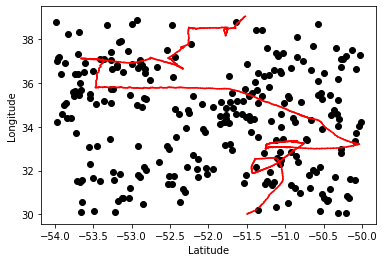

In [13]:
plt.scatter(box_interp.LATITUDE,box_interp.LONGITUDE,color='black',label='argo profiles')
plt.plot(ds_660_grid.latitude, ds_660_grid.longitude,color='r',label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

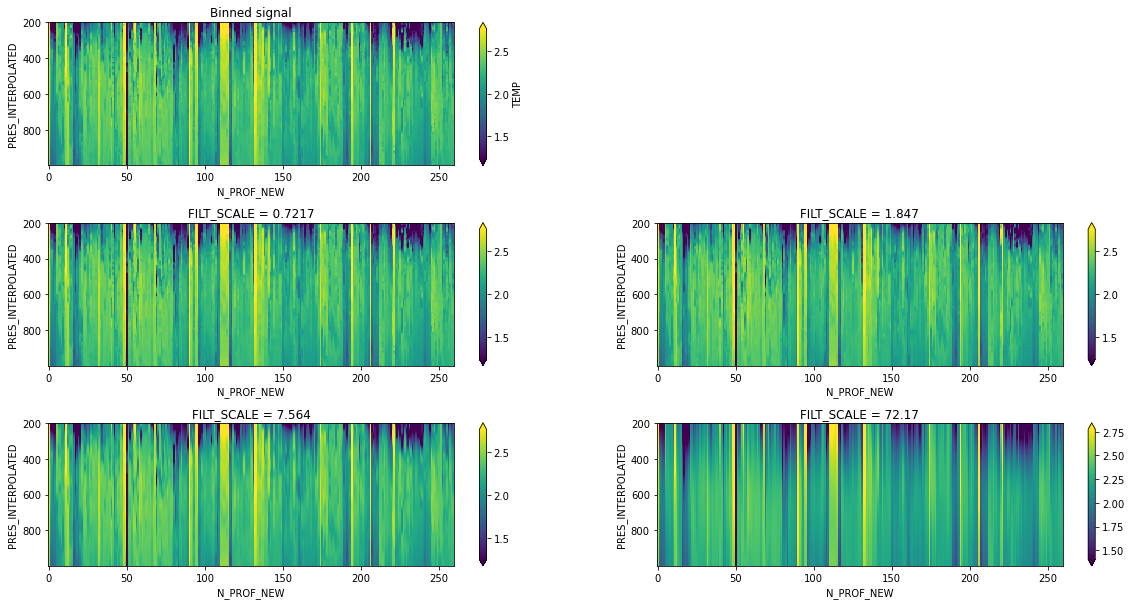

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
box_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
box_filt.isel(FILT_SCALE=0).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
box_filt.isel(FILT_SCALE=10).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
box_filt.isel(FILT_SCALE=25).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
box_filt.isel(FILT_SCALE=49).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

Text(0, 0.5, 'Variance ($^oC^2$)')

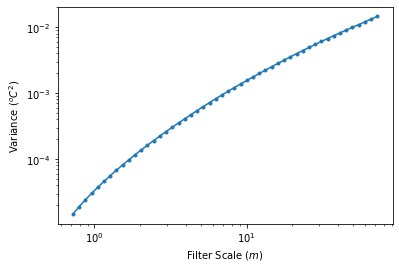

In [15]:
plt.plot(box_filt.FILT_SCALE,box_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [16]:
box_TEMP_spec=xrft.power_spectrum(box_interp.TEMP - box_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 0, '$\\lambda$ [1/m]')

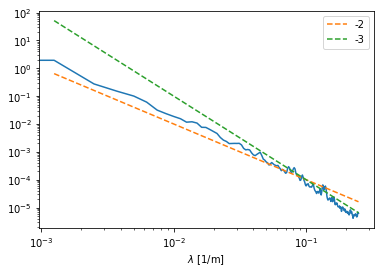

In [17]:
box_TEMP_spec.mean('N_PROF').plot()

kz = box_TEMP_spec.freq_PRES_INTERPOLATED

plt.plot(kz, 1e-6*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0, 0.5, 'Variance ($^oC^2$)')

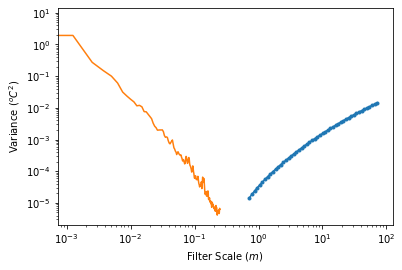

In [18]:
plt.plot(box_filt.FILT_SCALE,box_var,'.-')
box_TEMP_spec.mean('N_PROF').plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

### Argo "Event" Picker

This is a work in progress, but the general idea is to pick argo profiles by either time horizon or "event" (defined by similar surface conditions?) to see if the spectra/filtering signals are more clear

Text(0.5, 1.0, 'Binned signal')

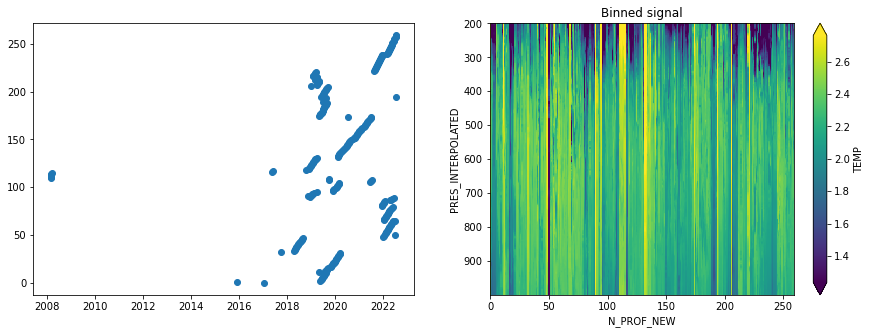

In [100]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(box_interp.TIME,box_interp.N_PROF_NEW)

plt.subplot(1,2,2)
box_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()
plt.title('Binned signal')

#looks like there are a number of profiles that occur in 2022, maybe there will be enough if we separate by time?

In [350]:
#reads in depth range and boundaries for different events and returns separate arrays with profiles whose average temp over
# that depth falls within the given range
def get_diff_events(ds,lim1_min,lim1_max,lim2_min,lim2_max,lim3_min,lim3_max,depth_min,depth_max):
    
    median1=ds.TEMP.where(ds.PRES_INTERPOLATED<depth_max).where(ds.PRES_INTERPOLATED>depth_min).mean('PRES_INTERPOLATED')
    ind_rate1=median1.where(median1<lim1_max,drop=True).where(median1>lim1_min,drop=True).N_PROF
    event1=ds.sel(N_PROF=ind_rate1)
    
    median2=ds.TEMP.where(ds.PRES_INTERPOLATED<depth_max).where(ds.PRES_INTERPOLATED>depth_min).mean('PRES_INTERPOLATED')
    ind_rate2=median2.where(median2<lim2_max,drop=True).where(median2>lim2_min,drop=True).N_PROF
    event2=ds.sel(N_PROF=ind_rate2)
    
    median3=ds.TEMP.where(ds.PRES_INTERPOLATED<depth_max).where(ds.PRES_INTERPOLATED>depth_min).mean('PRES_INTERPOLATED')
    ind_rate3=median3.where(median3<lim3_max,drop=True).where(median3>lim3_min,drop=True).N_PROF
    event3=ds.sel(N_PROF=ind_rate3)

    return(event1,event2,event3)

In [351]:
event1,event2,event3=get_diff_events(box_interp, 0,1.75, 1.75,2.25, 2.25,3.5, 200,400)

In [352]:
event1_filt=get_ds_filt(event1,1,3,50)
event1_var=get_var(event1,event1_filt)
event1_spec=xrft.power_spectrum(event1.TEMP - event1.TEMP.mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)

event2_filt=get_ds_filt(event2,1,3,50)
event2_var=get_var(event2,event2_filt)
event2_spec=xrft.power_spectrum(event2.TEMP - event2.TEMP.mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)

event3_filt=get_ds_filt(event3,1,3,50)
event3_var=get_var(event3,event3_filt)
event3_spec=xrft.power_spectrum(event3.TEMP - event3.TEMP.mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


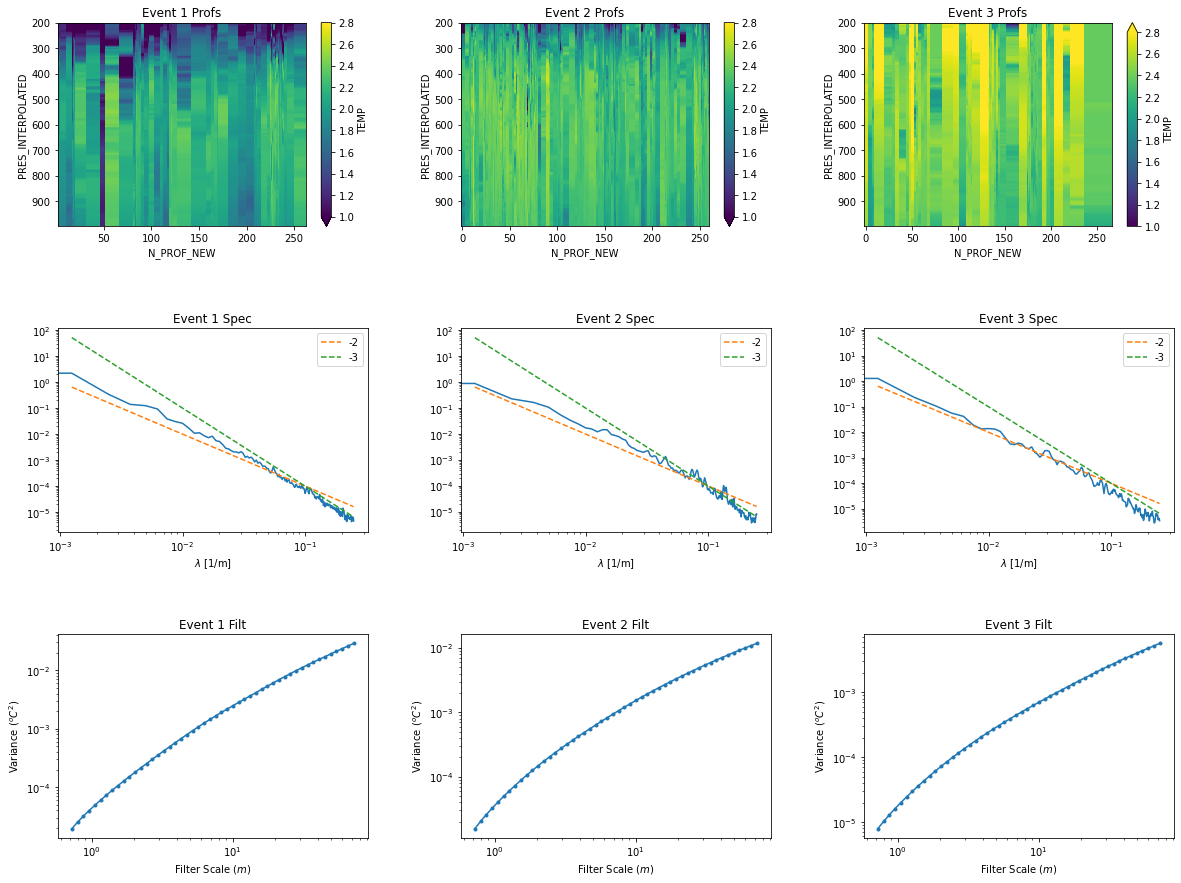

In [390]:
plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
event1.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=2.8)
plt.gca().invert_yaxis()
plt.title('Event 1 Profs')

plt.subplot(3,3,4)
event1_spec.mean('N_PROF').plot()
kz = event1_spec.freq_PRES_INTERPOLATED
plt.plot(kz, 1e-6*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.title('Event 1 Spec')

plt.subplot(3,3,7)
plt.plot(event1_filt.FILT_SCALE,event1_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.title('Event 1 Filt')

plt.subplot(3,3,2)
event2.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=2.8)
plt.gca().invert_yaxis()
plt.title('Event 2 Profs')

plt.subplot(3,3,5)
event2_spec.mean('N_PROF').plot()
kz = event2_spec.freq_PRES_INTERPOLATED
plt.plot(kz, 1e-6*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.title('Event 2 Spec')

plt.subplot(3,3,8)
plt.plot(event2_filt.FILT_SCALE,event2_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.title('Event 2 Filt')

plt.subplot(3,3,3)
event3.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=2.8)
plt.gca().invert_yaxis()
plt.title('Event 3 Profs')

plt.subplot(3,3,6)
event3_spec.mean('N_PROF').plot()
kz = event3_spec.freq_PRES_INTERPOLATED
plt.plot(kz, 1e-6*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-7*kz**(-3), '--', label='-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')
plt.title('Event 3 Spec')

plt.subplot(3,3,9)
plt.plot(event3_filt.FILT_SCALE,event3_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.title('Event 3 Filt')

plt.subplots_adjust(hspace=0.5,wspace=0.3)

In [ ]:
#reads in time boundaries and returns separate arrays whose profiles fall within the given range
def get_diff_times(lim1_min,lim1_max,lim2_min,lim2_max,lim3_min,lim3_max):
    ......
    ......
    return(time1,time2,time3)

In [372]:
box_interp.TIME

<xarray.DataArray 'TIME' (N_PROF: 260)>
array(['2017-01-14T13:25:03.000000000', '2015-11-27T11:05:41.000000000',
       '2019-05-19T22:13:50.000000000', '2019-05-29T21:37:34.000000000',
       '2019-06-08T21:01:31.000000000', '2019-06-18T20:36:21.000000000',
       '2019-06-28T20:44:01.000000000', '2019-07-08T20:17:24.000000000',
       '2019-07-18T19:56:20.000000000', '2019-07-28T19:24:03.000000256',
       '2019-08-07T19:24:55.000000000', '2019-05-03T18:36:37.000000000',
       '2019-08-01T14:43:38.000000000', '2019-08-21T14:16:30.000000000',
       '2019-08-31T13:57:27.000000000', '2019-09-10T13:51:35.000000000',
       '2019-10-20T13:21:30.000000000', '2019-10-30T13:47:15.000000000',
       '2019-11-09T14:01:19.000000256', '2019-11-19T13:17:45.000000000',
       '2019-11-29T12:59:40.000000256', '2019-12-09T12:29:52.000000000',
       '2019-12-19T12:09:54.000000000', '2019-12-29T12:11:31.000000000',
       '2020-01-08T13:02:18.000000000', '2020-01-18T13:13:17.000000000',
       '2020-01-28T13:07:34.000000000', '2020-02-07T12:59:31.000000000',
       '2020-02-17T12:31:23.000000000', '2020-02-27T12:11:32.000000000',
       '2020-03-08T12:14:01.000000256', '2020-03-18T12:16:10.000000000',
       '2017-09-20T18:11:42.000000000', '2018-04-09T20:41:43.000000000',
       '2018-04-19T22:02:06.000000000', '2018-04-29T22:56:40.000000000',
       '2018-05-09T23:42:04.999999744', '2018-05-20T00:37:03.000000000',
       '2018-05-30T01:12:14.000000000', '2018-06-09T01:57:52.000000256',
...
       '2021-08-19T02:02:14.000000000', '2021-08-20T05:32:58.000000000',
       '2021-08-29T23:34:16.000000000', '2021-09-08T17:48:45.000000000',
       '2021-09-18T12:02:12.000000000', '2021-09-19T15:37:34.000000000',
       '2021-09-29T09:47:29.999999744', '2021-10-09T04:01:50.000000000',
       '2021-10-18T22:14:50.000000000', '2021-10-20T01:55:16.000000256',
       '2021-10-29T20:03:48.000000000', '2021-11-08T14:11:16.000000256',
       '2021-11-18T08:04:25.000000000', '2021-11-19T11:27:47.000000256',
       '2021-11-29T05:43:02.000000000', '2021-12-08T23:15:40.000000000',
       '2021-12-18T17:17:29.999999744', '2021-12-19T21:08:44.000000000',
       '2022-02-27T18:23:00.000000000', '2022-03-09T12:08:14.000000000',
       '2022-03-19T06:03:14.000000000', '2022-03-20T08:32:11.000000000',
       '2022-03-30T02:27:09.000000000', '2022-04-08T20:30:20.000000000',
       '2022-04-18T14:32:35.000000000', '2022-04-19T16:45:57.000000000',
       '2022-04-29T10:41:58.000000000', '2022-05-09T04:36:59.000000000',
       '2022-05-18T22:27:05.000000000', '2022-05-20T00:31:07.000000256',
       '2022-05-29T18:20:57.999999744', '2022-06-08T12:11:51.999999744',
       '2022-06-18T06:02:32.000000000', '2022-06-19T08:07:48.000000000',
       '2022-06-29T02:18:16.000000000', '2022-07-08T20:06:38.000000000',
       '2022-07-18T14:11:29.000000000', '2022-07-19T16:31:57.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * N_PROF      (N_PROF) int64 452 454 455 456 457 ... 1567 1568 1569 1570 1571
    TIME        (N_PROF) datetime64[ns] 2017-01-14T13:25:03 ... 2022-07-19T16...
    LATITUDE    (N_PROF) float64 -50.34 -53.22 -52.38 ... -51.23 -51.12 -51.1
    LONGITUDE   (N_PROF) float64 37.57 30.12 30.57 30.47 ... 37.6 37.37 37.21
    N_PROF_NEW  (N_PROF) int64 0 1 2 3 4 5 6 7 ... 253 254 255 256 257 258 259
Attributes:
    long_name:      Datetime (UTC) of the station
    standard_name:  time
    casted:         1